# BVCBM prior samples and biphasic simulations
This notebook snippet draws samples from the biphasic prior and runs the simulator at those draws.

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from precond_npe_misspec.examples import bvcbm

try:
    from scipy.io import loadmat
except ModuleNotFoundError as exc:
    raise ModuleNotFoundError(
        "scipy is required to read '.mat' files. Install it with `uv run --with scipy` or `pip install scipy`."
    ) from exc

plt.style.use("ggplot")

/Users/ryankelly/python_projects/preconditioned-npe-under-misspecification/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
T = 32  # simulation horizon (days)
start_volume = 50.0
page = 5
num_prior_draws = 100

key = jax.random.key(0)
prior = bvcbm.prior_biphasic(T)
key_samples, key_sims = jax.random.split(key)
theta_samples = prior.sample(key_samples, sample_shape=(num_prior_draws,))
theta_samples_np = np.asarray(theta_samples)
parameter_labels = [
    # "p0_1",
    # "psc_1",
    # "dmax_1",
    "gage_1",
    "tau",
    # "p0_2",
    # "psc_2",
    # "dmax_2",
    "gage_2",
]
pd.DataFrame(theta_samples_np, columns=parameter_labels)

,gage_1,tau,gage_2
0,646.370300,7.288981,175.791245
1,94.355110,7.562591,554.341492
2,587.565857,6.423673,730.055298
3,24.422506,4.862606,425.154602
4,97.202034,19.242300,736.010437
...,...,...,...
95,592.179138,13.129053,460.736450
96,521.147461,28.914274,577.832092
97,118.721710,11.808325,165.824799
98,543.293030,28.937378,657.708679


In [3]:
sim = bvcbm.simulator_biphasic(T=T, start_volume=start_volume, page=page)
sim_seed_ints = jax.random.randint(
    key_sims, shape=(num_prior_draws,), minval=0, maxval=2**31 - 1, dtype=jnp.int32
)
sim_results = [
    sim(theta, int(seed))
    for theta, seed in zip(theta_samples_np, np.asarray(sim_seed_ints))
]
sim_results = np.asarray(sim_results, dtype=float)
sim_results

array([[  71.13115692,   78.48548889,   85.93759155, ..., 2635.28149414,
        2998.33007812, 3272.01757812],
       [  81.05834198,   82.99627686,   88.14103699, ..., 1149.16149902,
        1426.09924316, 1603.62133789],
       [  82.522789  ,   91.15582275,   98.58953857, ...,  138.20483398,
         207.02185059,  249.14933777],
       ...,
       [  63.63825989,   78.90364838,   88.24266815, ..., 3710.07202148,
        4275.41552734, 4598.75976562],
       [  53.59228897,   55.16627884,   56.10847473, ...,  146.98391724,
         148.83630371,  148.3434906 ],
       [  50.76789856,   51.12155151,   51.35426331, ...,   97.50246429,
          93.17825317,  113.02435303]], shape=(100, 32))

In [4]:
prior_summary_log = np.asarray([bvcbm.summary_identity(s) for s in sim_results])
prior_summary_log.shape

(100, 32)

In [5]:
data_path = Path("../src/precond_npe_misspec/data/CancerDatasets.mat")
mat = loadmat(data_path)
control_growth = np.asarray(mat["Pancreatic_data"], dtype=float)
control_growth_0 = control_growth[:T, 0]
control_growth_1 = control_growth[:T, 1]
control_growth_2 = control_growth[:T, 2]
control_growth_3 = control_growth[:T, 3]

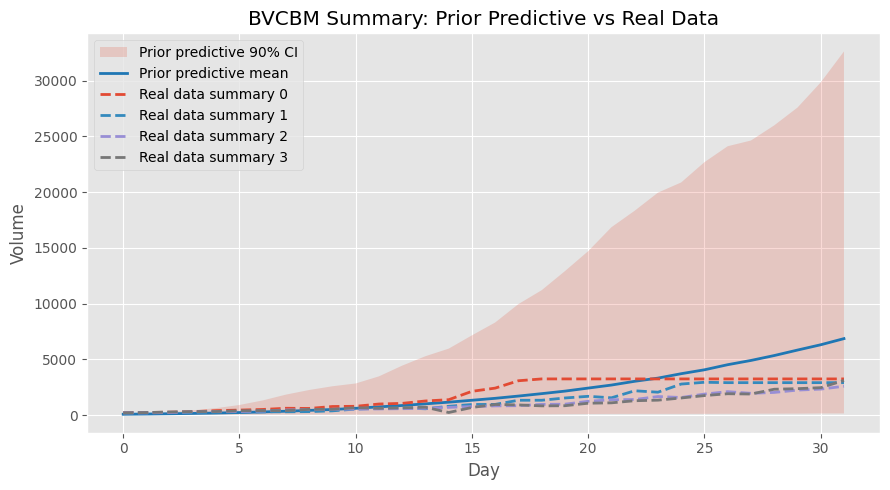

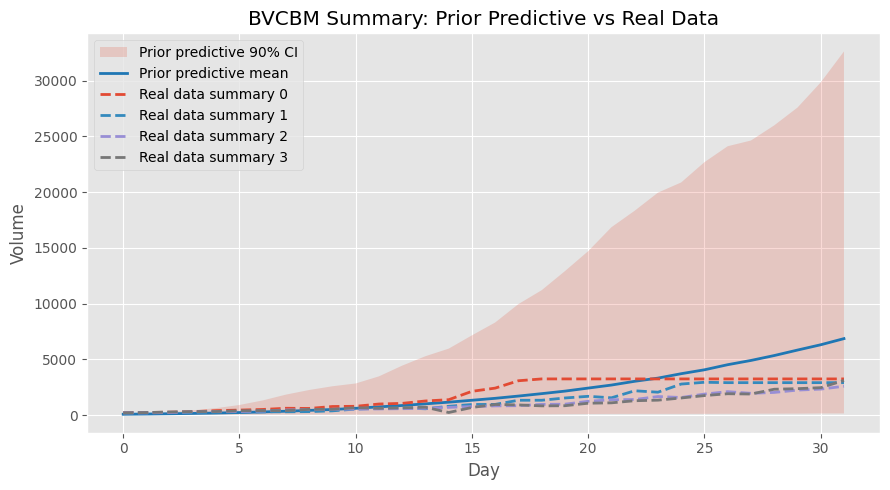

In [6]:
time_idx = np.arange(prior_summary_log.shape[1])
prior_lower, prior_upper = np.percentile(prior_summary_log, [5, 95], axis=0)
prior_mean = prior_summary_log.mean(axis=0)

fig, ax = plt.subplots(figsize=(9, 5))
ax.fill_between(
    time_idx, prior_lower, prior_upper, alpha=0.2, label="Prior predictive 90% CI"
)
ax.plot(
    time_idx, prior_mean, color="tab:blue", linewidth=2, label="Prior predictive mean"
)

real_data = [control_growth_0, control_growth_1, control_growth_2, control_growth_3]

for i in range(len(real_data)):
    ax.plot(
        time_idx,
        real_data[i],
        linewidth=2,
        linestyle="--",
        label=f"Real data summary {i}",
    )
ax.set_xlabel("Day")
ax.set_ylabel("Volume")
ax.set_title("BVCBM Summary: Prior Predictive vs Real Data")
ax.legend()
fig.tight_layout()
fig

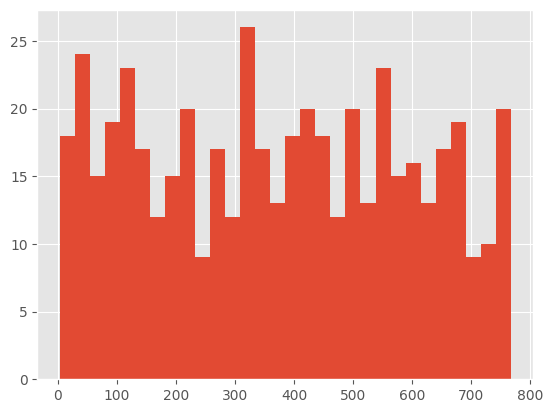

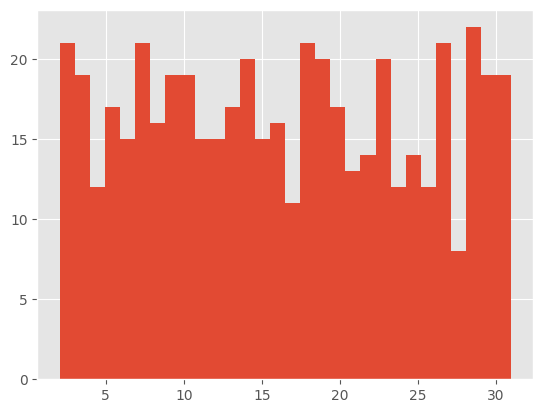

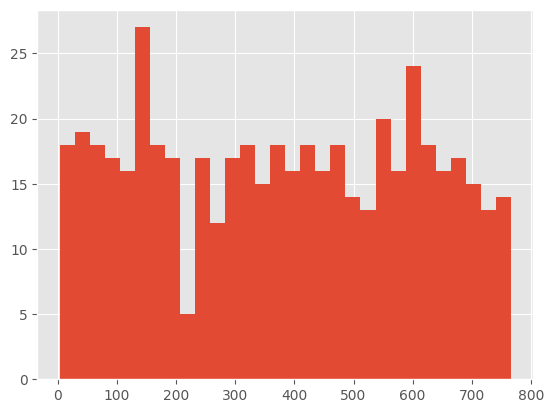

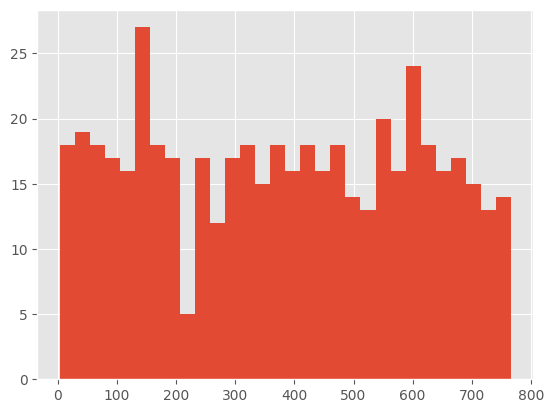

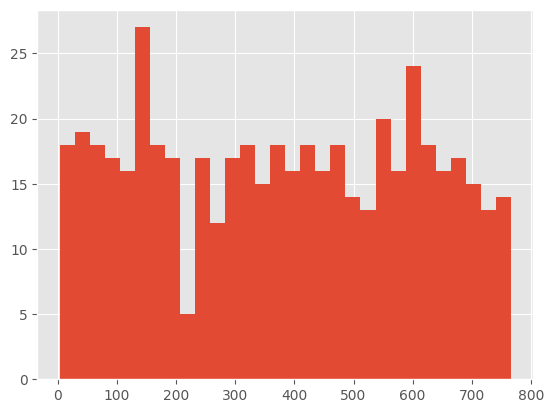

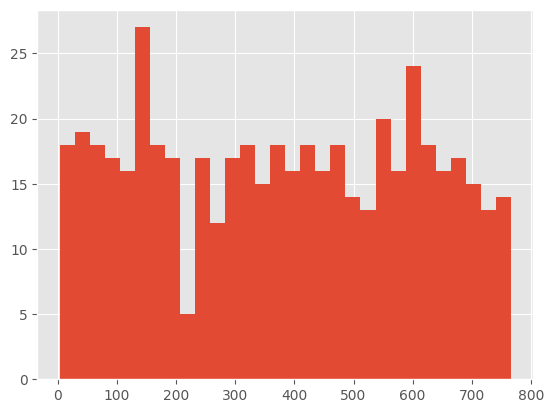

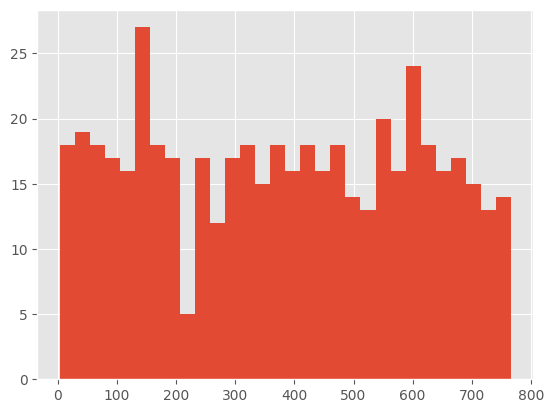

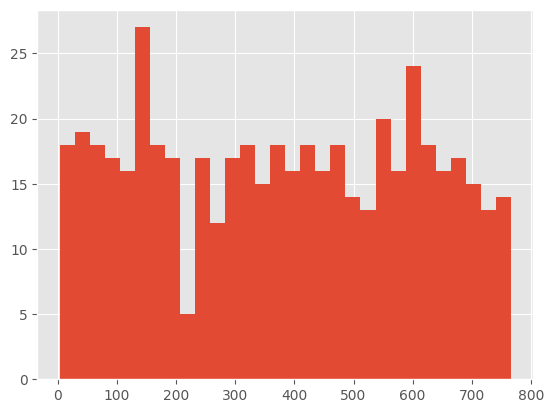

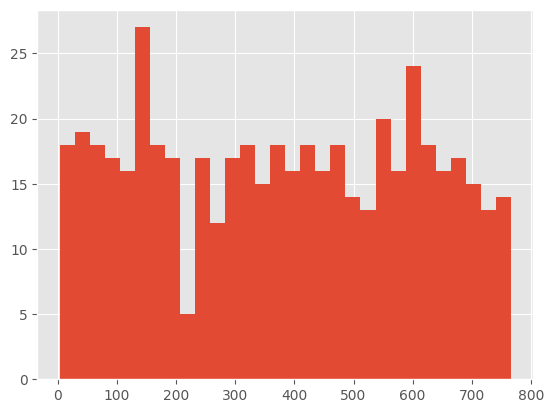

In [7]:
rng_key = jax.random.key(1)
prior_samples = prior.sample(rng_key, sample_shape=(500,))
for i in range(9):
    plt.hist(prior_samples[:, i], bins=30)
    plt.show()